# Machine Learning for Wine Color and Quality Classification

In [180]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from matplotlib.lines import Line2D

In [120]:
# Retrieve data
df = pd.read_csv("winequalityN.csv")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [122]:
df["quality"].unique() # Note that only the quality labels 3-9 are present

array([6, 5, 7, 8, 4, 3, 9])

## 1. Data cleaning

In [123]:
# drop missing values
print("Missing values in each column:/n", df.isnull().sum())

Missing values in each column:/n type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [124]:
# drop NA values
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# Encode type as binary variable
winetype = pd.get_dummies(df.type)
df = pd.concat([df, winetype], axis='columns')
df= df.drop(['type', 'white'], axis='columns') # type: 1 = red, 0 = white

# renaming the columns for simplicity
df.rename(columns={'red':'type', 'fixed acidity':'fixed_acidity', 'volatile acidity':'volatile_acidity', 'citric acid':'citric_acid', 'residual sugar':'residual_sugar', 'free sulfur dioxide':'free_sulf_diox', 'total sulfur dioxide':'total_sulf_diox'}, inplace=True)

In [125]:
# Scaling
set_config(transform_output="pandas")
columns_to_scale = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulf_diox', 'total_sulf_diox', 'density', 'pH', 'sulphates', 'alcohol']
scaler = ColumnTransformer([("scale", StandardScaler(), columns_to_scale)], remainder='passthrough',)
df_scaled = scaler.fit_transform(df)

# renaming the columns for simplicity
df_scaled.rename(columns={'scale__fixed_acidity':'fixed_acidity', 'scale__volatile_acidity':'volatile_acidity', 'scale__citric_acid':'citric_acid', 'scale__residual_sugar':'residual_sugar', 'scale__free_sulf_diox':'free_sulf_diox', 'scale__total_sulf_diox':'total_sulf_diox', 'scale__chlorides':'chlorides', 'scale__density':'density', 'scale__pH':'pH', 'scale__sulphates':'sulphates', 'scale__alcohol':'alcohol', 'remainder__quality':'quality', 'remainder__type':'type'}, inplace=True)

## 2. Data Exploration

### 2.1 Distribution of wine type

percentage of red:  0.24647996286554233


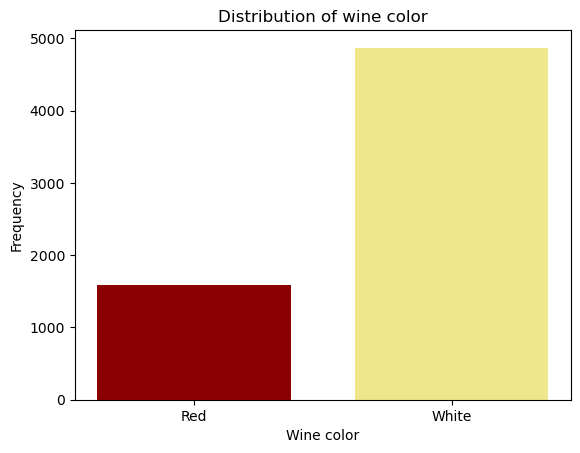

In [244]:
red_count = df_scaled["type"].sum()
white_count = df_scaled.shape[0]-red_count
plt.bar(["Red", "White"], [red_count, white_count], color = ["darkred", "khaki"], width=0.75)
plt.title("Distribution of wine color")
plt.xlabel("Wine color")
plt.ylabel("Frequency")
#plt.savefig('Distribution_of_wine_color.png', bbox_inches='tight')
print("percentage of red: ", red_count/(red_count+white_count))

### 2.2 Distribution of wine quality

In [221]:
# Distribution of wine quality
qualities = np.array(df_scaled["quality"].unique())
count_per_quality = df_scaled.groupby(["quality"]).count().type

Text(0, 0.5, 'Frequency')

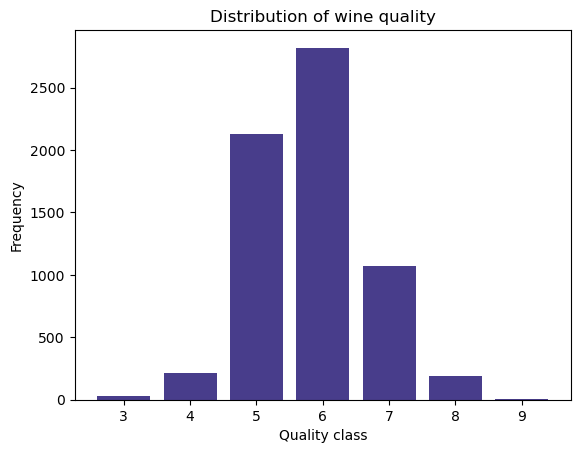

In [228]:
plt.bar(np.sort(qualities), count_per_quality, color = "darkslateblue")
plt.title("Distribution of wine quality")
plt.xlabel("Quality class")
plt.ylabel("Frequency")
#plt.savefig('Distribution_of_wine_quality.png', bbox_inches='tight')

## 3. Predicting Wine Color

In [294]:
# Split in training and test data

train_data_frac = 0.7

train = df_scaled.sample(frac = train_data_frac, random_state = 20)
test = df_scaled.drop(train.index)

# seperate response from covariates (we also drop quality here)

train_cov = train.drop(["quality", "type"], axis=1)
train_resp = train["type"]

test_cov = test.drop(["quality", "type"], axis=1)
test_resp = test["type"]

### 3.1 Logistic Regression

In [295]:
log = lm.LogisticRegression(penalty = None)
log.fit(train_cov, train_resp)

LogisticRegression(penalty=None)

In [296]:
test_pred_log = log.predict(test_cov)
print("Hemming loss is: ", metrics.hamming_loss(test_resp, test_pred_log)

SyntaxError: incomplete input (1601494051.py, line 2)

In [297]:
print("Log loss is: ", metrics.log_loss(test_resp, log.predict_proba(test_cov))

SyntaxError: incomplete input (2989316143.py, line 1)

### 3.2 Neural Network

### 3.3 Feature Importance

## 2. Linear Regression

In [277]:
# Split in training and test data

train_data_frac = 0.7

train = df_scaled.sample(frac = train_data_frac, random_state = 20)
test = df_scaled.drop(train.index)

# seperate response from covariates

train_cov = train.drop("quality", axis=1)
train_resp = train["quality"]

test_cov = test.drop("quality", axis=1)
test_resp = test["quality"]

In [278]:
reg = lm.LinearRegression()
reg.fit(train_cov, train_resp)

LinearRegression()

In [279]:
print(reg.coef_)
print(reg.intercept_)

[ 0.11613509 -0.23816159 -0.00734506  0.29126213 -0.02708688  0.07565959
 -0.07632882 -0.28983247  0.08292891  0.09999545  0.27233389  0.31681955]
5.733820023070848


In [280]:
test_pred_reg = np.round(reg.predict(test_cov))
metrics.hamming_loss(test_resp, test_pred_reg)

0.4657039711191336

In [281]:
metrics.mean_squared_error(test_resp, test_pred_reg)

0.591542031975245

In [282]:
train_pred_reg = np.round(reg.predict(train_cov))
metrics.hamming_loss(train_resp, train_pred_reg)

0.46640141467727675

In [286]:
(np.round(reg.predict(test_cov)) == test_resp).sum()/test_resp.shape[0]

0.5342960288808665

## 3. Logistic Regression

In [288]:
log = lm.LogisticRegression(penalty = None)
log.fit(train_cov, train_resp)

/Users/fs/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None)

In [289]:
test_pred_log = log.predict(test_cov)
metrics.hamming_loss(test_resp, test_pred_log)

0.45074780814853016

In [133]:
metrics.mean_squared_error(test_resp, test_pred_log)

0.6173285198555957

## 4. Neural Network

,scale__fixed_acidity,scale__volatile_acidity,scale__citric_acid,scale__residual_sugar,scale__chlorides,scale__free_sulf_diox,scale__total_sulf_diox,scale__density,scale__pH,scale__sulphates,scale__alcohol,remainder__quality,remainder__type
0,-0.167786,-0.422710,0.283959,3.207420,-0.315228,0.815609,0.960779,2.099926,-1.359160,-0.544987,-1.418922,6,0
1,-0.707155,-0.240479,0.146257,-0.808151,-0.201180,-0.930138,0.288479,-0.232465,0.508399,-0.276354,-0.832184,6,0
2,0.679794,-0.361966,0.559363,0.306117,-0.172668,-0.029107,-0.330745,0.134053,0.259391,-0.612146,-0.329265,6,0
3,-0.013681,-0.665684,0.008554,0.642500,0.055427,0.928238,1.243853,0.300653,-0.176373,-0.880779,-0.496905,6,0
4,-0.013681,-0.665684,0.008554,0.642500,0.055427,0.928238,1.243853,0.300653,-0.176373,-0.880779,-0.496905,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,-0.321892,1.703315,-1.643871,-0.745079,0.340545,-0.141736,-1.374580,0.603864,1.255423,1.939871,-0.832184,6,1
6459,-0.784208,1.581828,-1.643871,-0.724055,0.967807,0.083522,-1.268427,0.067414,1.442179,0.328071,0.006014,5,1
6460,-0.707155,1.035136,-1.299616,-0.660984,0.568640,-0.085421,-1.339195,0.347301,1.255423,1.469762,0.425113,6,1
6461,-1.015366,1.855174,-1.368467,-0.724055,0.540129,0.083522,-1.268427,0.257337,2.189203,1.201129,-0.245446,5,1


In [23]:
dummies

,red,white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
6458,1,0
6459,1,0
6460,1,0
6461,1,0


In [35]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulf_diox,total_sulf_diox,density,pH,sulphates,alcohol,quality,type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1
6459,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6460,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6461,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


# Wine color

In [136]:
# Split in training and test data

train_data_frac = 0.7

train = df_scaled.sample(frac = train_data_frac, random_state = 20)
test = df_scaled.drop(train.index)

# seperate response from covariates

train_cov = train.drop(["quality", "type"], axis=1)
train_resp = train["type"]

test_cov = test.drop(["quality", "type"], axis=1)
test_resp = test["type"]

In [141]:
log = lm.LogisticRegression(penalty = None)
log.fit(train_cov, train_resp)

LogisticRegression(penalty=None)

In [142]:
test_pred_log = np.round(log.predict(test_cov))
metrics.hamming_loss(test_resp, test_pred_log)

0.0036101083032490976

In [143]:
print(log.coef_)

[[-0.2234355   1.10700335 -0.23964762 -3.8834452   0.73886525  1.1519509
  -2.81313087  4.73543466 -0.06733277  0.44710206  1.96976076]]


In [250]:
metrics.log_loss(test_resp, log.predict_proba(test_cov))

0.015235926583661163

In [146]:
Forest = RandomForestClassifier()
Forest.fit(train_cov, train_resp)
Forest.score(test_cov,  test_resp)

0.997421351211965

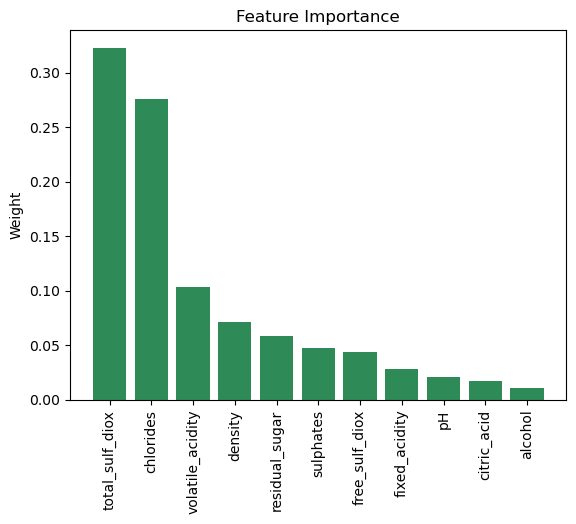

In [254]:
FeatureImportance = pd.DataFrame({
    'Covariates' : train_cov.columns,
    'Importance' : Forest.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
_ = plt.bar(FeatureImportance.Covariates, FeatureImportance.Importance, color = "seagreen")
_ = plt.xticks(rotation=90)
_ = plt.title("Feature Importance")
_ = plt.ylabel("Weight")
#plt.savefig('Feature_Importance.png', bbox_inches='tight')

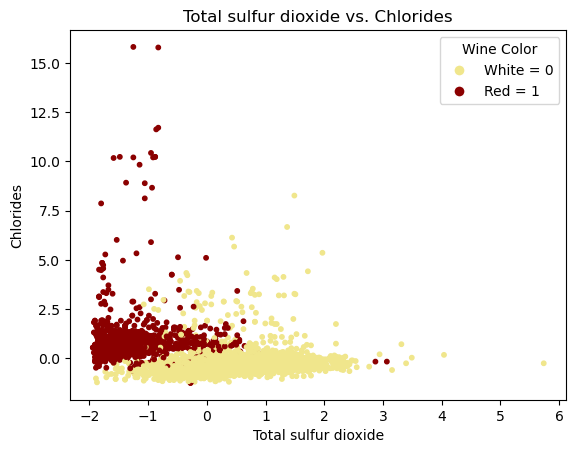

In [265]:
colors = train_resp.map({0: 'khaki', 1: 'darkred'})
scatter = plt.scatter(train_cov["total_sulf_diox"], train_cov["chlorides"], c = colors, s = 10)
legend_labels = ['White = 0', 'Red = 1']
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='khaki', markersize=8),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8)]
_ = plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", title="Wine Color")
_ = plt.xlabel("Total sulfur dioxide")
_ = plt.ylabel("Chlorides")
_ = plt.title("Total sulfur dioxide vs. Chlorides")
#plt.savefig('Scatter_sulfur_chlorides.png', bbox_inches='tight')

In [258]:
train_cov_restricted = train_cov[["total_sulf_diox", "chlorides"]]
test_cov_restricted = test_cov[["total_sulf_diox", "chlorides"]]

In [259]:
Forest = RandomForestClassifier()
Forest.fit(train_cov_restricted, train_resp)
Forest.score(test_cov_restricted,  test_resp)

0.9778236204228984

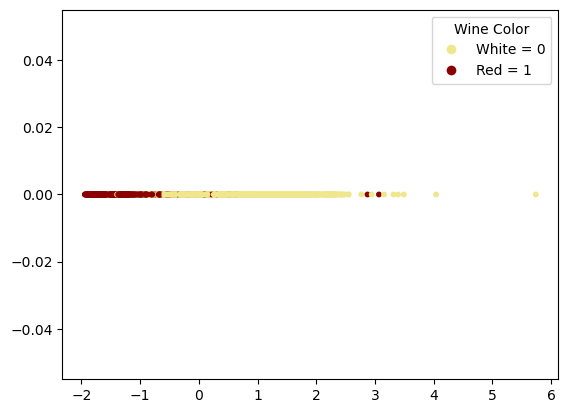

In [262]:
colors = train_resp.map({0: 'khaki', 1: 'darkred'})
scatter = plt.scatter(train_cov["total_sulf_diox"], np.zeros(train_cov.shape[0]), c = colors, s = 10)
legend_labels = ['White = 0', 'Red = 1']
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='khaki', markersize=8),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8)]
_ = plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", title="Wine Color")